### | 기본 필요 패키지 Import

In [1]:
import pandas as pd
import numpy as np
import warnings
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

### | Text 가공에 필요한 패키지 Import

In [25]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from profanity_check import predict, predict_prob
from nltk import FreqDist
import string
import re

### | Modeling에 필요한 패키지 Import

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

### | Text Tokenize 함수 정의

In [57]:
def tokenize(df):
    c_df = df.copy()
    col_name = 'comment_text'
    
    # 토크나이저로 전체 문장을 단어별로 분할, 토크나이저는 RegexTokenizer사용
    c_df[col_name] = c_df[col_name].apply(lambda x : RegexpTokenizer(r'\w+').tokenize(x.lower()))
    
    # Lemmatizer로 단어를 원형으로 표기
    l = WordNetLemmatizer()
    c_df[col_name] = c_df[col_name].apply(lambda x : [l.lemmatize(word) for word in x])
    
    # StopWords 제거
    stop_words = stopwords.words('english')
    c_df[col_name] = c_df[col_name].apply(lambda x : [word for word in x if word not in stop_words])
    
    # 숫자 제거
    c_df[col_name] = c_df[col_name].apply(lambda x : re.findall('[a-z]+', ' '.join(x)))
    
    return c_df

### | Data Preprocessing 함수 정의

In [5]:
def make_features(df):
    
    c_df = df.copy()
    
    col_name = 'comment_text'
    
    
    # 전체 문장의 길이
    c_df['tot_len'] = c_df[col_name].apply(lambda x : len(x))
       
    
    # 개행문자의 개수
    c_df['nl'] = c_df[col_name].str.findall(r'\n').str.len()
    
    
    # you 라는 지칭대명사의 count개수
    c_df['you'] = c_df[col_name].str.lower().str.findall(r'you').str.len()
    
    
    # 대문자가 얼마나 포함되어있는가
    c_df['Cap'] = c_df[col_name].str.findall(r'[A-Z]').str.len()
    
    
    # 느낌표 사용횟수
    c_df['exclamation'] = c_df[col_name].str.findall(r'\!').str.len()
    
    
    # 물음표 사용횟수
    c_df['question'] = c_df[col_name].str.findall(r'\?').str.len()
    
    
    # smile_emoji 사용여부
    smile_emoji = [':-)', ':)', ';-)', ';)', ':P', ';P', ':D', ';D', '<3']
    c_df['smile'] = c_df[col_name].apply(lambda x : sum([1 for word in x.split() if word in smile_emoji]))
    
    
    # Stopword 개수 파악
    stop_words = set(stopwords.words('english'))
    c_df['stop_words'] = c_df[col_name].apply(lambda x: sum([1 for word in x.split() if word in stop_words]))
    
    
    # Punctuation 사용 개수 파악
    c_df['punc'] = c_df[col_name].apply(lambda x: sum([1 for word in x.split() if word in string.punctuation]))
    
    
    return c_df.drop(columns=col_name, axis=1)




# make_features2 함수의 경우, 인자 값으로 t_pre를 수행한 df를 받는다.
def make_features2(df):
    c_df = df.copy()
    
    col_name = 'comment_text'
    
    # 비속어 포함개수
    c_df['profanity'] = c_df[col_name].apply(lambda x : predict(x).sum() if len(x) > 0 else 0)
    
    # 문장 내에서 반복되는 단어의 최빈값
    c_df['most_rep'] = c_df[col_name].apply(lambda x : FreqDist(np.hstack(x)).most_common(1)[0][1] if len(x) > 0 else 0)
    
    return c_df.drop(columns=col_name, axis=1)

In [2]:
d_path = 'jigsaw-toxic-comment-classification-challenge'
original_df = pd.read_csv(d_path + '/train.csv')

# 텍스트 Feature만을 담고 있는 df texts 정의
texts = original_df['comment_text'].to_frame()

# Label 전체의 정보를 담고 있는 df vicious 정의
vicious = original_df.iloc[:, 2:]

# 악의성 여부만을 담고 있는 df label 정의
label = original_df.iloc[:, 2:].sum(axis=1).map(lambda x : 1 if x > 0 else 0).to_frame().rename(columns={0 : 'label'})

In [3]:
original_df

id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
0           0             0        0       0       0              0  
1           0             0        0       0       0              0  
2           0             0        0       0       0              0  
3           0             0        0       0       0              0  
4           0             0        0       0       0              0  
...       ...           ...      ...     ...     ...            ...  
159566      0             0        0       0       0              0  
159567      0             0        0       0       0              0  
159568      0             0        0       0       0              0  
159569      0             0        0       0       0              0  
159570      0             0        0       0       0              0  

[159571 rows x 8 columns]

In [58]:
# tokenize 함수의 결과값을 지닌 token_words 변수 선언
token_words = tokenize(texts)

In [59]:
token_words

comment_text
0       [explanation, edits, made, username, hardcore,...
1       [aww, match, background, colour, seemingly, st...
2       [hey, man, really, trying, edit, war, guy, con...
3       [make, real, suggestion, improvement, wondered...
4                     [sir, hero, chance, remember, page]
...                                                   ...
159566  [second, time, asking, view, completely, contr...
159567        [ashamed, horrible, thing, put, talk, page]
159568  [spitzer, umm, actual, article, prostitution, ...
159569  [look, like, wa, actually, put, speedy, first,...
159570  [really, think, understand, came, idea, wa, ba...

[159571 rows x 1 columns]

In [60]:
# 토큰화 과정에서 빈 리스트로 반환된 값들은 Stopwords들로만 구성된 값들이다.

token_words[token_words['comment_text'].map(len) == 0]

comment_text
2098             []
2407             []
3990             []
4482             []
6300             []
8846             []
9395             []
12414            []
17311            []
23529            []
25718            []
26401            []
31072            []
32019            []
38313            []
43293            []
47072            []
52442            []
53787            []
58603            []
61758            []
64304            []
70162            []
71720            []
74759            []
79776            []
82232            []
82681            []
85302            []
93867            []
96828            []
100782           []
101669           []
104000           []
109581           []
110514           []
114172           []
114620           []
119899           []
124454           []
124619           []
125837           []
126952           []
128604           []
129074           []
140477           []
142859           []
146126           []
147917           []
148865           []
151379           []
152817           []
153315           []
159019           []

In [61]:
len(token_words[token_words['comment_text'].map(len) == 0])

54

In [62]:
# 위에서 빈리스트로 반환된 원래 텍스트 값을 살펴보면 다음과 같다.

empty_lists = token_words[token_words['comment_text'].map(len) == 0][:10].index


for idx in empty_lists:
    print('\n{}\'s original Text :'.format(idx))
    print(texts.iloc[[idx]].values.tolist()[0])


2098's original Text :
['No, it doesn´t.80.228.65.162']

2407's original Text :
['Here, here and here.']

3990's original Text :
['From here\n\nFrom here 160.80.2.8']

4482's original Text :
['1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n\n1999\n\n2000\n\n2001\n\n2002\n\n2003']

6300's original Text :
['193.61.111.53  15:00']

8846's original Text :
['What is I 78.146.102.144']

9395's original Text :
['They do too.  their ... -']

12414's original Text :
["You're just at it again!"]

17311's original Text :
['~ \n\n68.193.147.157']

23529's original Text :
['between 1991 and 1999']


In [63]:
# 추후 모델링 작업을 위한 working df 선언
w_df = pd.concat([make_features(texts), make_features2(token_words)], axis=1)

In [64]:
w_df

tot_len  nl  you  Cap  exclamation  question  smile  stop_words  punc  \
0           264   1    0   17            0         1      0          14     0   
1           112   0    0    8            1         0      0           1     0   
2           233   0    0    4            0         0      0          18     0   
3           622   4    2   11            0         0      0          49     4   
4            67   0    2    2            0         1      0           4     0   
...         ...  ..  ...  ...          ...       ...    ...         ...   ...   
159566      295   2    3    2            0         2      0          18     2   
159567       99   2    3    2            0         0      0           9     0   
159568       81   2    0    4            0         0      0           2     1   
159569      116   0    1    2            0         0      0          13     0   
159570      189   1    2    4            0         0      0           9     2   

        profanity  most_rep  
0               0         1  
1               0         1  
2               0         1  
3               0         2  
4               0         1  
...           ...       ...  
159566          0         2  
159567          1         1  
159568          0         1  
159569          0         2  
159570          0         2  

[159571 rows x 11 columns]

In [65]:
w_df = pd.concat([w_df, label], axis=1)

In [66]:
w_df

tot_len  nl  you  Cap  exclamation  question  smile  stop_words  punc  \
0           264   1    0   17            0         1      0          14     0   
1           112   0    0    8            1         0      0           1     0   
2           233   0    0    4            0         0      0          18     0   
3           622   4    2   11            0         0      0          49     4   
4            67   0    2    2            0         1      0           4     0   
...         ...  ..  ...  ...          ...       ...    ...         ...   ...   
159566      295   2    3    2            0         2      0          18     2   
159567       99   2    3    2            0         0      0           9     0   
159568       81   2    0    4            0         0      0           2     1   
159569      116   0    1    2            0         0      0          13     0   
159570      189   1    2    4            0         0      0           9     2   

        profanity  most_rep  label  
0               0         1      0  
1               0         1      0  
2               0         1      0  
3               0         2      0  
4               0         1      0  
...           ...       ...    ...  
159566          0         2      0  
159567          1         1      0  
159568          0         1      0  
159569          0         2      0  
159570          0         2      0  

[159571 rows x 12 columns]

In [67]:
# 새로 만든 특징들에서 결측치는 없다.

w_df.isnull().sum()

tot_len        0
nl             0
you            0
Cap            0
exclamation    0
question       0
smile          0
stop_words     0
punc           0
profanity      0
most_rep       0
label          0
dtype: int64

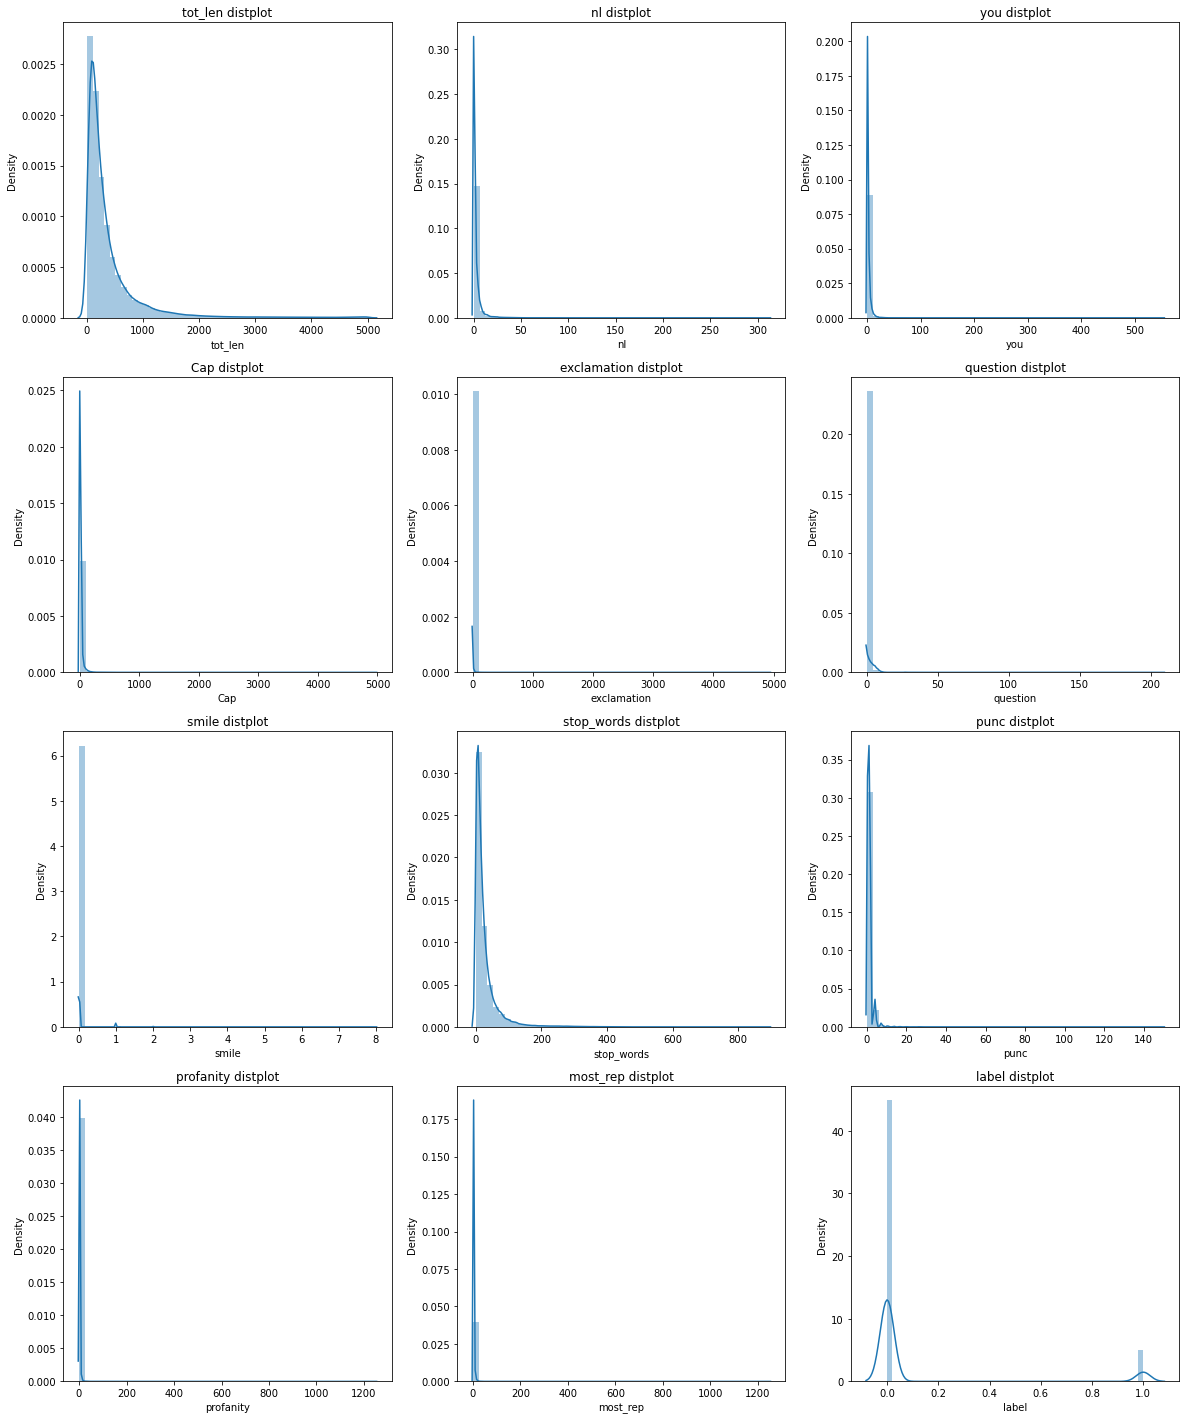

In [68]:
# w_df 의 데이터 분포는 다음과 같다.

n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))

for idx, col in enumerate(w_df.columns):
    sns.distplot(w_df[col], ax=axes[idx // n_cols, idx % n_cols]);
    axes[idx // n_cols, idx % n_cols].set_title('{} distplot'.format(col));

In [69]:
w_df.label.value_counts(normalize=True)

0    0.898321
1    0.101679
Name: label, dtype: float64

In [70]:
vicious

toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]

In [71]:
# Label의 분포도 확인

for col in vicious.columns:
    print('{}\'s distribution'.format(col))
    display(vicious[col].value_counts(normalize=True))

toxic's distribution


0    0.904156
1    0.095844
Name: toxic, dtype: float64

severe_toxic's distribution


0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64

obscene's distribution


0    0.947052
1    0.052948
Name: obscene, dtype: float64

threat's distribution


0    0.997004
1    0.002996
Name: threat, dtype: float64

insult's distribution


0    0.950636
1    0.049364
Name: insult, dtype: float64

identity_hate's distribution


0    0.991195
1    0.008805
Name: identity_hate, dtype: float64

In [72]:
# 테스트를 진행할 df 선언

# toxic 여부만
t1_df = pd.concat([w_df.drop(columns='label', axis=1), vicious['toxic']], axis=1)


# severe toxic 여부만
t2_df = pd.concat([w_df.drop(columns='label', axis=1), vicious['severe_toxic']], axis=1)


#  obscene 여부만
t3_df = pd.concat([w_df.drop(columns='label', axis=1), vicious['obscene']], axis=1)


# threat 여부만
t4_df = pd.concat([w_df.drop(columns='label', axis=1), vicious['threat']], axis=1)


# insult 여부만
t5_df = pd.concat([w_df.drop(columns='label', axis=1), vicious['insult']], axis=1)


# identity_hate 여부만
t6_df = pd.concat([w_df.drop(columns='label', axis=1), vicious['identity_hate']], axis=1)

In [73]:
token_words

comment_text
0       [explanation, edits, made, username, hardcore,...
1       [aww, match, background, colour, seemingly, st...
2       [hey, man, really, trying, edit, war, guy, con...
3       [make, real, suggestion, improvement, wondered...
4                     [sir, hero, chance, remember, page]
...                                                   ...
159566  [second, time, asking, view, completely, contr...
159567        [ashamed, horrible, thing, put, talk, page]
159568  [spitzer, umm, actual, article, prostitution, ...
159569  [look, like, wa, actually, put, speedy, first,...
159570  [really, think, understand, came, idea, wa, ba...

[159571 rows x 1 columns]

In [74]:
token_words.squeeze()

0         [explanation, edits, made, username, hardcore,...
1         [aww, match, background, colour, seemingly, st...
2         [hey, man, really, trying, edit, war, guy, con...
3         [make, real, suggestion, improvement, wondered...
4                       [sir, hero, chance, remember, page]
                                ...                        
159566    [second, time, asking, view, completely, contr...
159567          [ashamed, horrible, thing, put, talk, page]
159568    [spitzer, umm, actual, article, prostitution, ...
159569    [look, like, wa, actually, put, speedy, first,...
159570    [really, think, understand, came, idea, wa, ba...
Name: comment_text, Length: 159571, dtype: object

In [75]:
# 토큰화 시킨 텍스트의 평균적인 단어수는 35개이다.
token_words['comment_text'].map(len).mean()

35.33835722029692

In [80]:
from gensim.models import Word2Vec

embedding_model = Word2Vec(token_words.squeeze(), size=40, iter=100, window=2, min_count=1000, sample=1e-3, workers=-1, sg=1)

# size = 임베딩의 결과로 반환할 차원의 수
# alpha = learning rate
# window = 모델이 학습할 때, 앞뒤로 보는 단어의 수
# min_count = 학습에 사용할 최소 단어빈도수

In [81]:
# 모델의 트레이닝이 완료되면 init_sims 명령어로 필요없는 메모리의 낭비를 줄인다.
embedding_model.init_sims(replace=True)

In [125]:
embedding_model.most_similar('stupid')

[('freedom', 0.5571020841598511),
 ('fuck', 0.49650269746780396),
 ('english', 0.3966546654701233),
 ('death', 0.38514673709869385),
 ('good', 0.37962132692337036),
 ('g', 0.3727486729621887),
 ('edits', 0.36979997158050537),
 ('line', 0.3631739020347595),
 ('thought', 0.3625769317150116),
 ('necessary', 0.3462124466896057)]

In [152]:
embedding_model2 = Word2Vec(token_words.squeeze(), size=49, iter=100, window=5, min_count=999, sample=1e-3, workers=-1, sg=1)

In [153]:
embedding_model2.init_sims(replace=True)

In [155]:
embedding_model2.most_similar('english')

[('wp', 0.4692612588405609),
 ('area', 0.43621426820755005),
 ('power', 0.40159037709236145),
 ('death', 0.38095635175704956),
 ('country', 0.3523561358451843),
 ('conflict', 0.34741610288619995),
 ('south', 0.3340288996696472),
 ('appropriate', 0.3289299011230469),
 ('rather', 0.3262616991996765),
 ('current', 0.323006272315979)]

In [164]:
embedding_model2.wv.doesnt_match('man woman child kitchen'.split())

'man'

In [196]:
embedding_model3 = Word2Vec(token_words.squeeze(), size=300, iter=100, window=10, min_count=50, sample=1e-3, workers=-1, sg=1)

In [197]:
embedding_model3.init_sims(replace=True)

In [214]:
embedding_model3.most_similar('king')

[('chunk', 0.21987321972846985),
 ('nato', 0.20210397243499756),
 ('nearly', 0.196519136428833),
 ('dad', 0.19549545645713806),
 ('classification', 0.19207331538200378),
 ('regular', 0.1832759976387024),
 ('paste', 0.18107476830482483),
 ('peru', 0.1786118447780609),
 ('uniform', 0.17274096608161926),
 ('lean', 0.17161527276039124)]

In [199]:
embedding_model3.wv.doesnt_match('man woman child kitchen'.split())

'child'

In [200]:
word_vectors_03 = embedding_model3.wv

In [201]:
vocabs_03 = word_vectors.vocab.keys()

In [204]:
vocabs_03

dict_keys(['explanation', 'edits', 'made', 'username', 'fan', 'reverted', 'vandalism', 'new', 'please', 'remove', 'template', 'talk', 'page', 'since', 'background', 'thanks', 'january', 'utc', 'hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'removing', 'relevant', 'information', 'talking', 'instead', 'seems', 'care', 'actual', 'info', 'make', 'real', 'suggestion', 'section', 'later', 'type', 'think', 'reference', 'may', 'need', 'date', 'etc', 'one', 'else', 'doe', 'first', 'style', 'want', 'let', 'know', 'appears', 'article', 'review', 'guess', 'turn', 'listed', 'form', 'wikipedia', 'good', 'chance', 'remember', 'well', 'use', 'tool', 'around', 'work', 'ha', 'banned', 'sorry', 'word', 'nonsense', 'wa', 'anyway', 'write', 'anything', 'would', 'merely', 'requesting', 'school', 'almost', 'stub', 'point', 'short', 'give', 'must', 'someone', 'subject', 'fair', 'rationale', 'image', 'jpg', 'notice', 'used', 'addition', 'also', 'description', 'specific', 'using', 'go', 'include', 'upl

In [205]:
word_vectors_list_03 = [word_vectors[v] for v in vocabs_03]

In [206]:
tsne_03 = TSNE(n_components=2, init='random', random_state=42)

xys_03 = tsne.fit_transform(word_vectors_list_03)
xs_03 = xys_03[:,0]
ys_03 = xys_03[:,1]

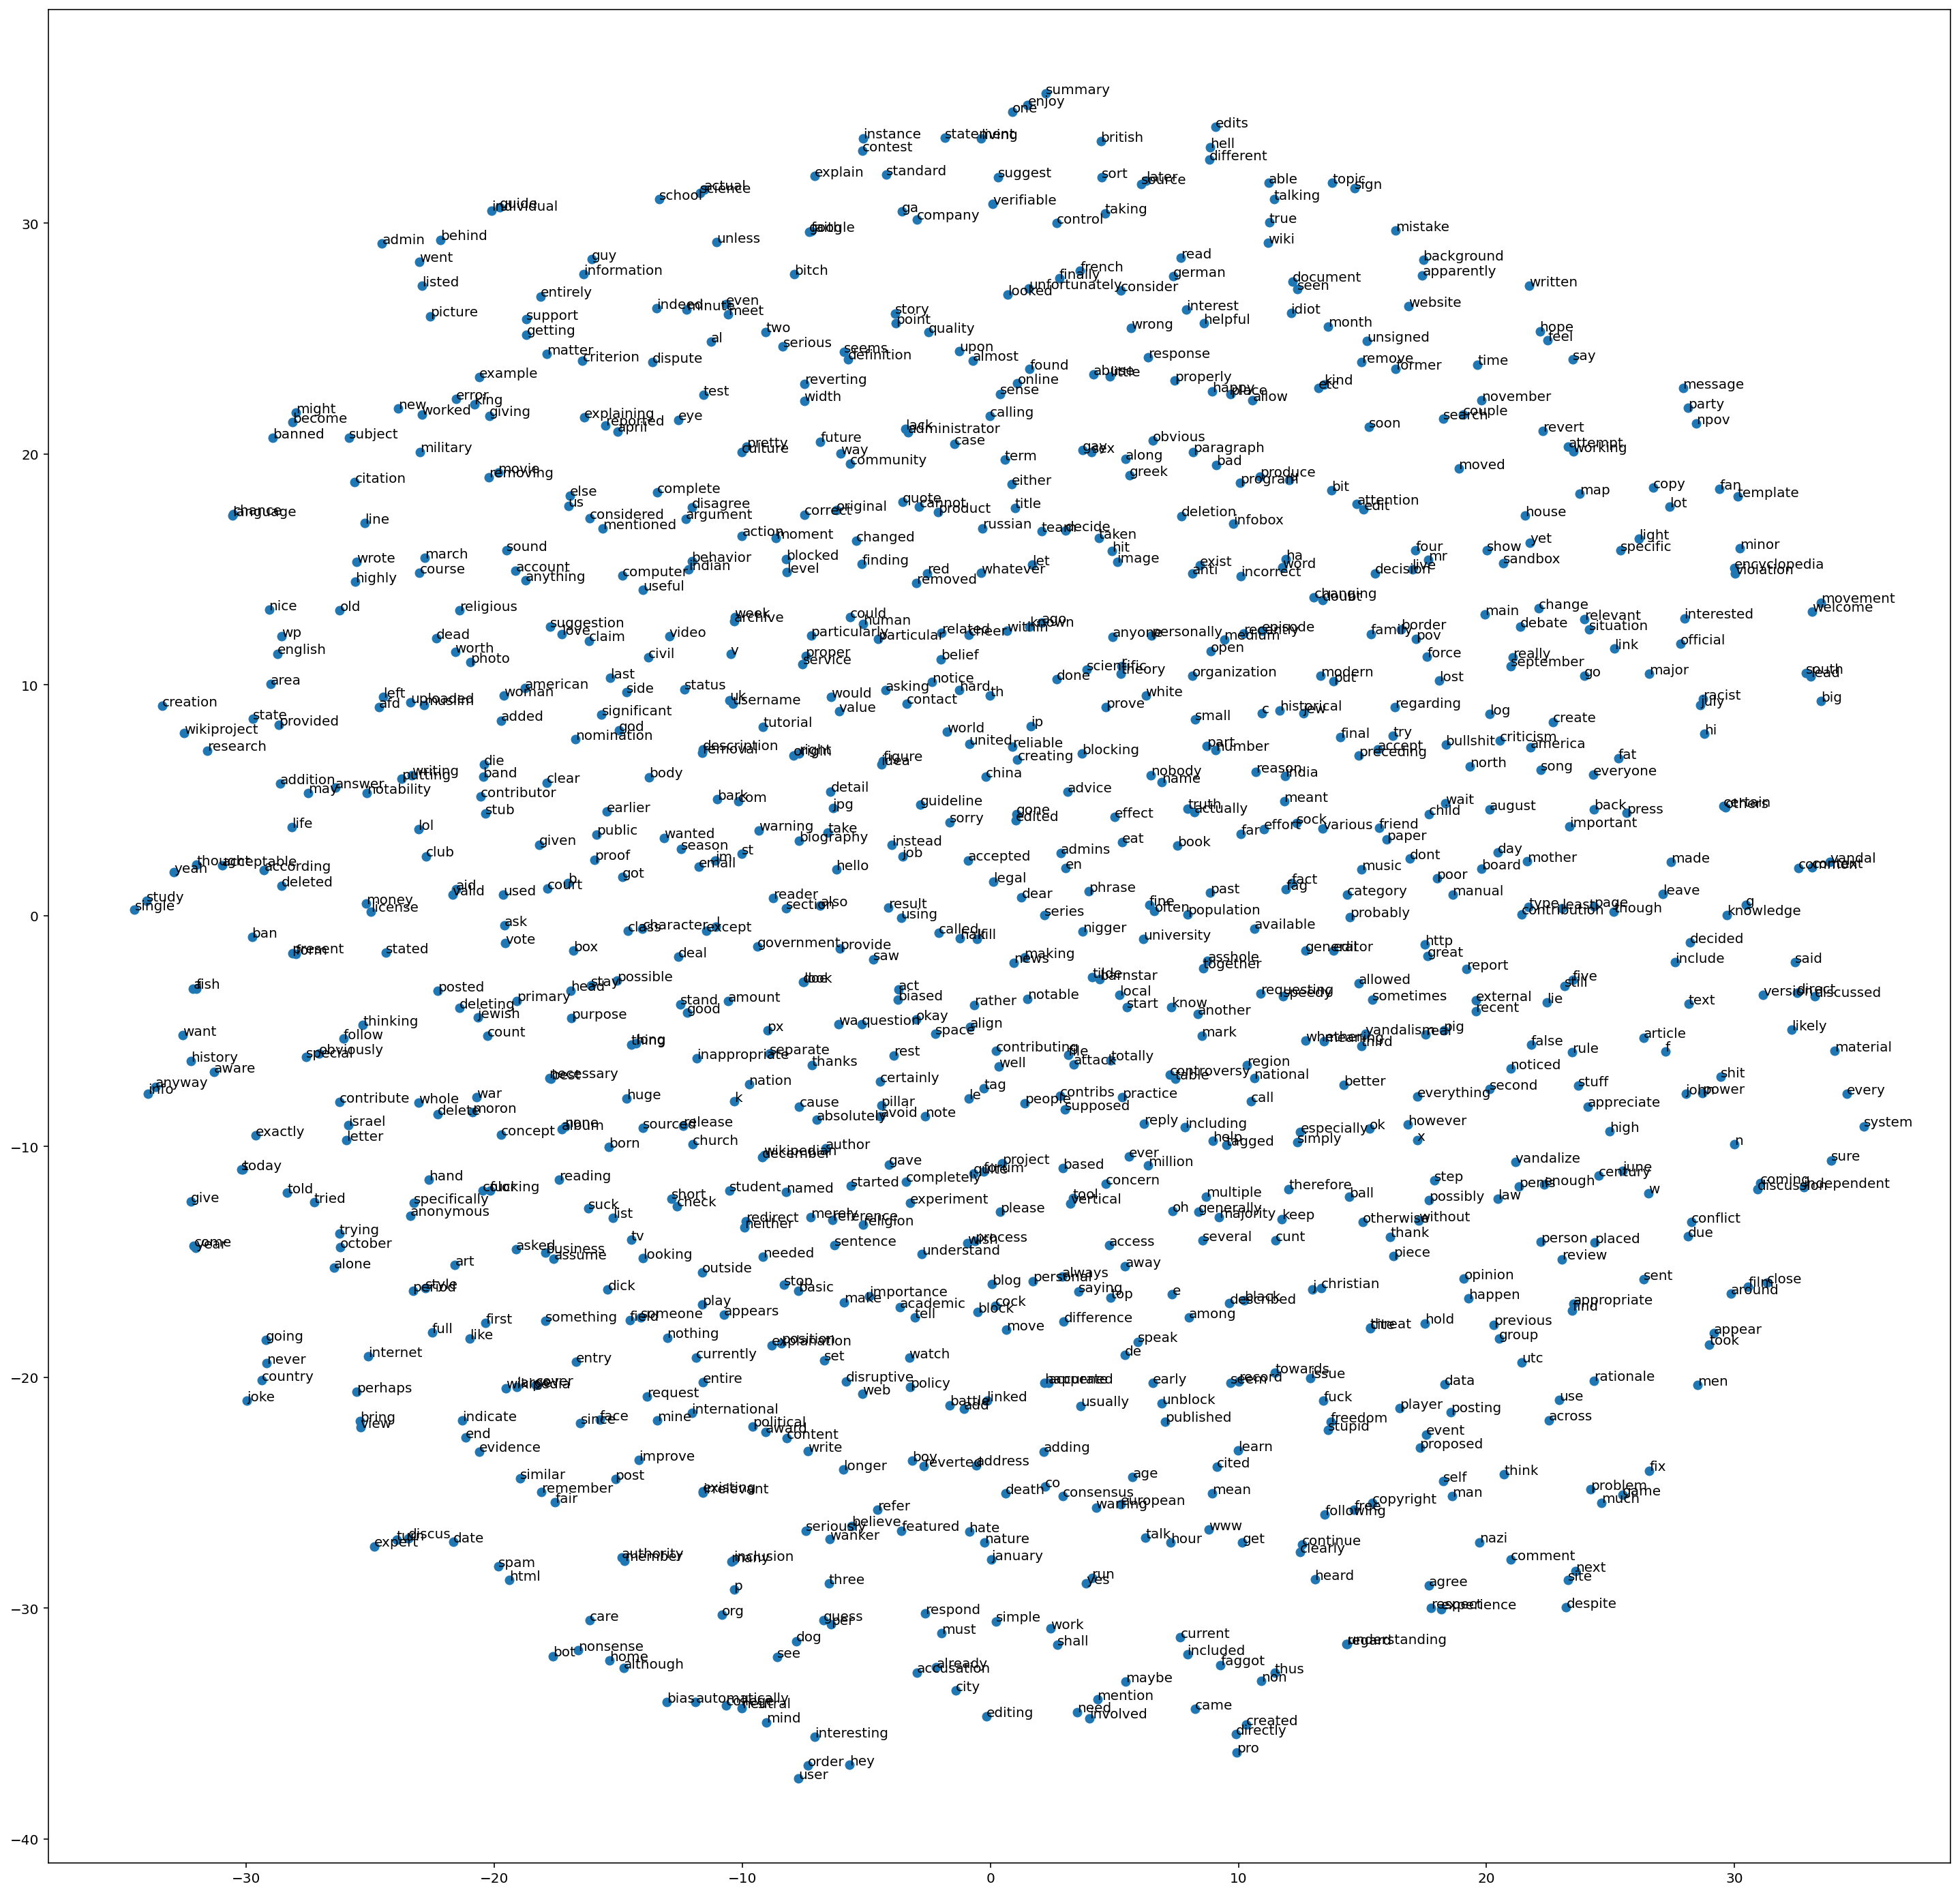

In [209]:
plt.figure(figsize=(25, 25))

plt.scatter(xs_03, ys_03)

for i, v in enumerate(vocabs_03):
    plt.annotate(v, xy=(xs_03[i], ys_03[i]))
    
plt.show()

In [210]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
xys_03 = pca.fit_transform(word_vectors_list_03)
xs_03 = xys_03[:,0]
ys_03 = xys_03[:,1]

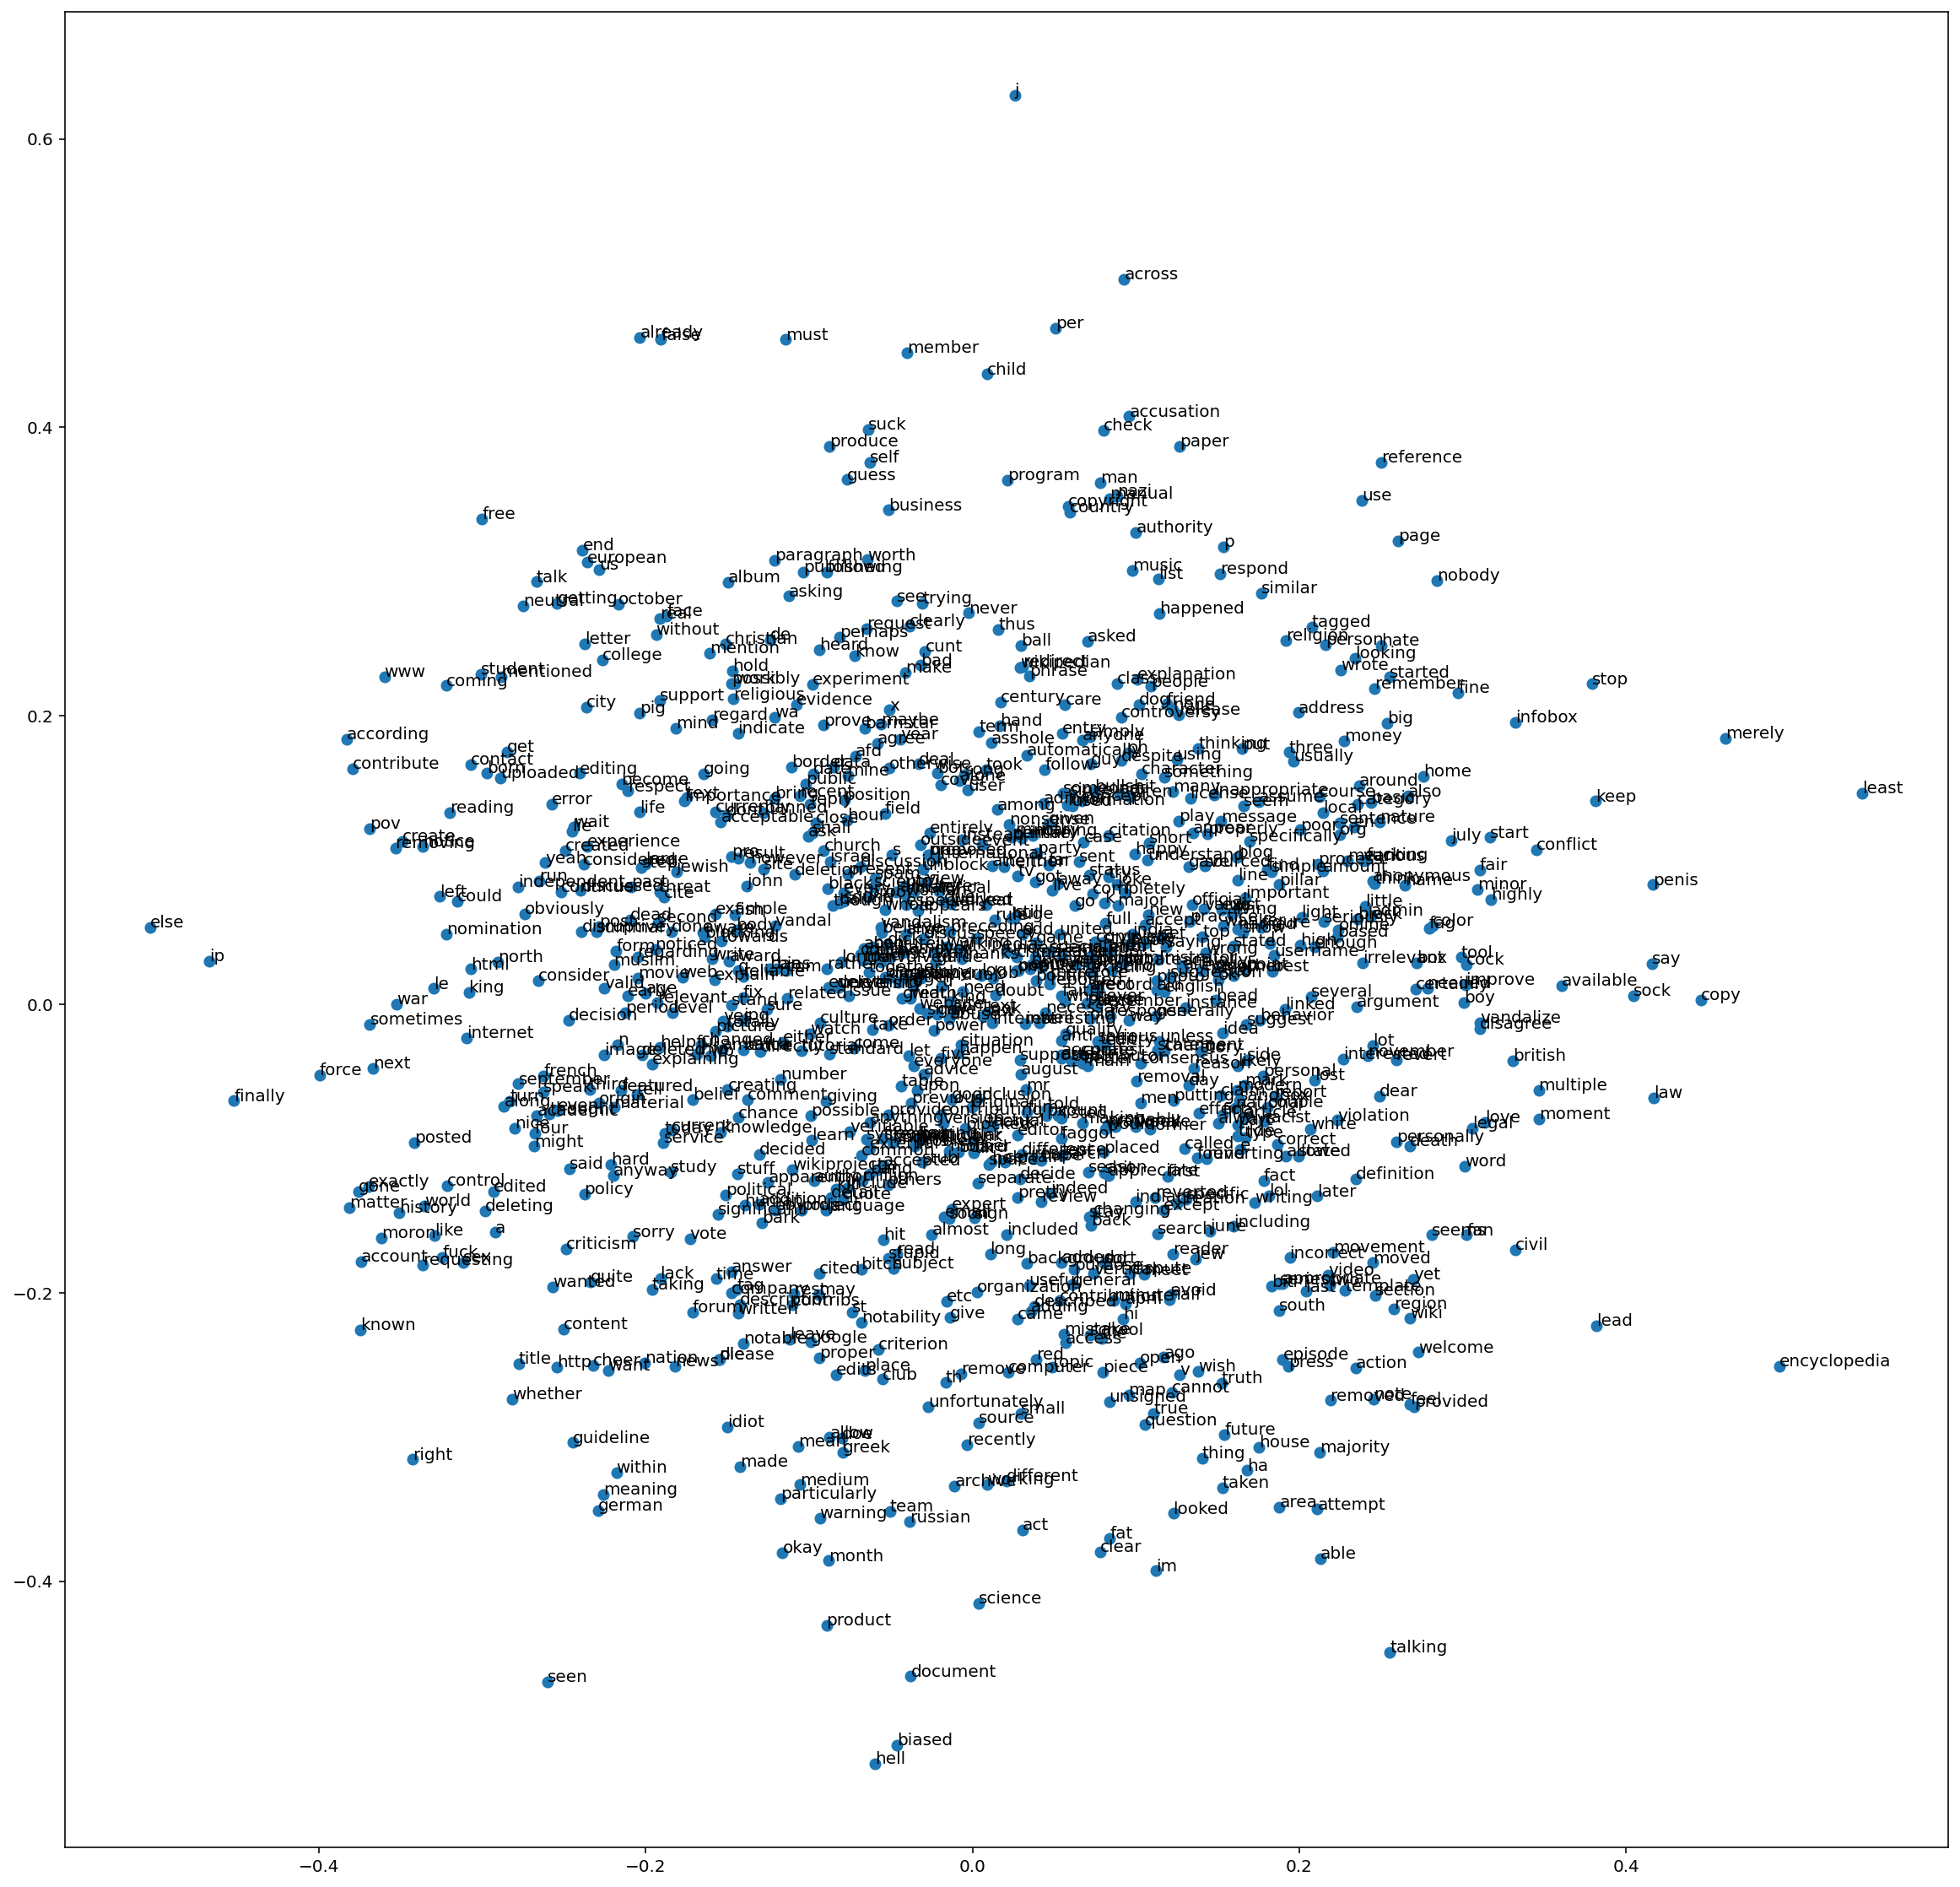

In [211]:
plot_2d_graph(vocabs_03, xs_03, ys_03)

In [107]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20 ,20))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

In [156]:
word_vectors = embedding_model2.wv

In [157]:
vocabs = word_vectors.vocab.keys()

In [158]:
vocabs

dict_keys(['explanation', 'edits', 'made', 'username', 'fan', 'reverted', 'vandalism', 'new', 'please', 'remove', 'template', 'talk', 'page', 'since', 'background', 'thanks', 'january', 'utc', 'hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'removing', 'relevant', 'information', 'talking', 'instead', 'seems', 'care', 'actual', 'info', 'make', 'real', 'suggestion', 'section', 'later', 'type', 'think', 'reference', 'may', 'need', 'date', 'etc', 'one', 'else', 'doe', 'first', 'style', 'want', 'let', 'know', 'appears', 'article', 'review', 'guess', 'turn', 'listed', 'form', 'wikipedia', 'good', 'chance', 'remember', 'well', 'use', 'tool', 'around', 'work', 'ha', 'banned', 'sorry', 'word', 'nonsense', 'wa', 'anyway', 'write', 'anything', 'would', 'merely', 'requesting', 'school', 'almost', 'stub', 'point', 'short', 'give', 'must', 'someone', 'subject', 'fair', 'rationale', 'image', 'jpg', 'notice', 'used', 'addition', 'also', 'description', 'specific', 'using', 'go', 'include', 'upl

In [160]:
word_vectors_list = [word_vectors[v] for v in vocabs]

In [215]:
word_vectors_list

[array([ 0.09513255,  0.22850792,  0.1805987 ,  0.05810825,  0.04577899,
         0.19731756, -0.23831941, -0.25000286,  0.18134405,  0.09376029,
         0.15210643,  0.03622179,  0.16722533,  0.11471359,  0.02101045,
        -0.23740982,  0.23890449,  0.17332472, -0.08437073,  0.17826834,
        -0.05112413, -0.1661876 , -0.17603183,  0.02442214, -0.01332478,
         0.05263289, -0.17079365, -0.19651033,  0.03326239,  0.07907767,
         0.18954124, -0.20464288, -0.0914389 , -0.03324132, -0.06255209,
        -0.1501947 , -0.21543635,  0.04225927,  0.07042222, -0.04170626,
        -0.0109393 , -0.06417598,  0.08540805, -0.21566895, -0.10274576,
         0.16040762,  0.15668684, -0.10271919,  0.11983974], dtype=float32),
 array([ 0.23548758,  0.05469374, -0.19674234,  0.12527415,  0.07393204,
        -0.06426539, -0.04976554, -0.13879706, -0.06214562, -0.01681664,
         0.1028663 , -0.14416116, -0.07571052, -0.04635544,  0.22129755,
        -0.04119711, -0.18307915,  0.16441134, 

In [161]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

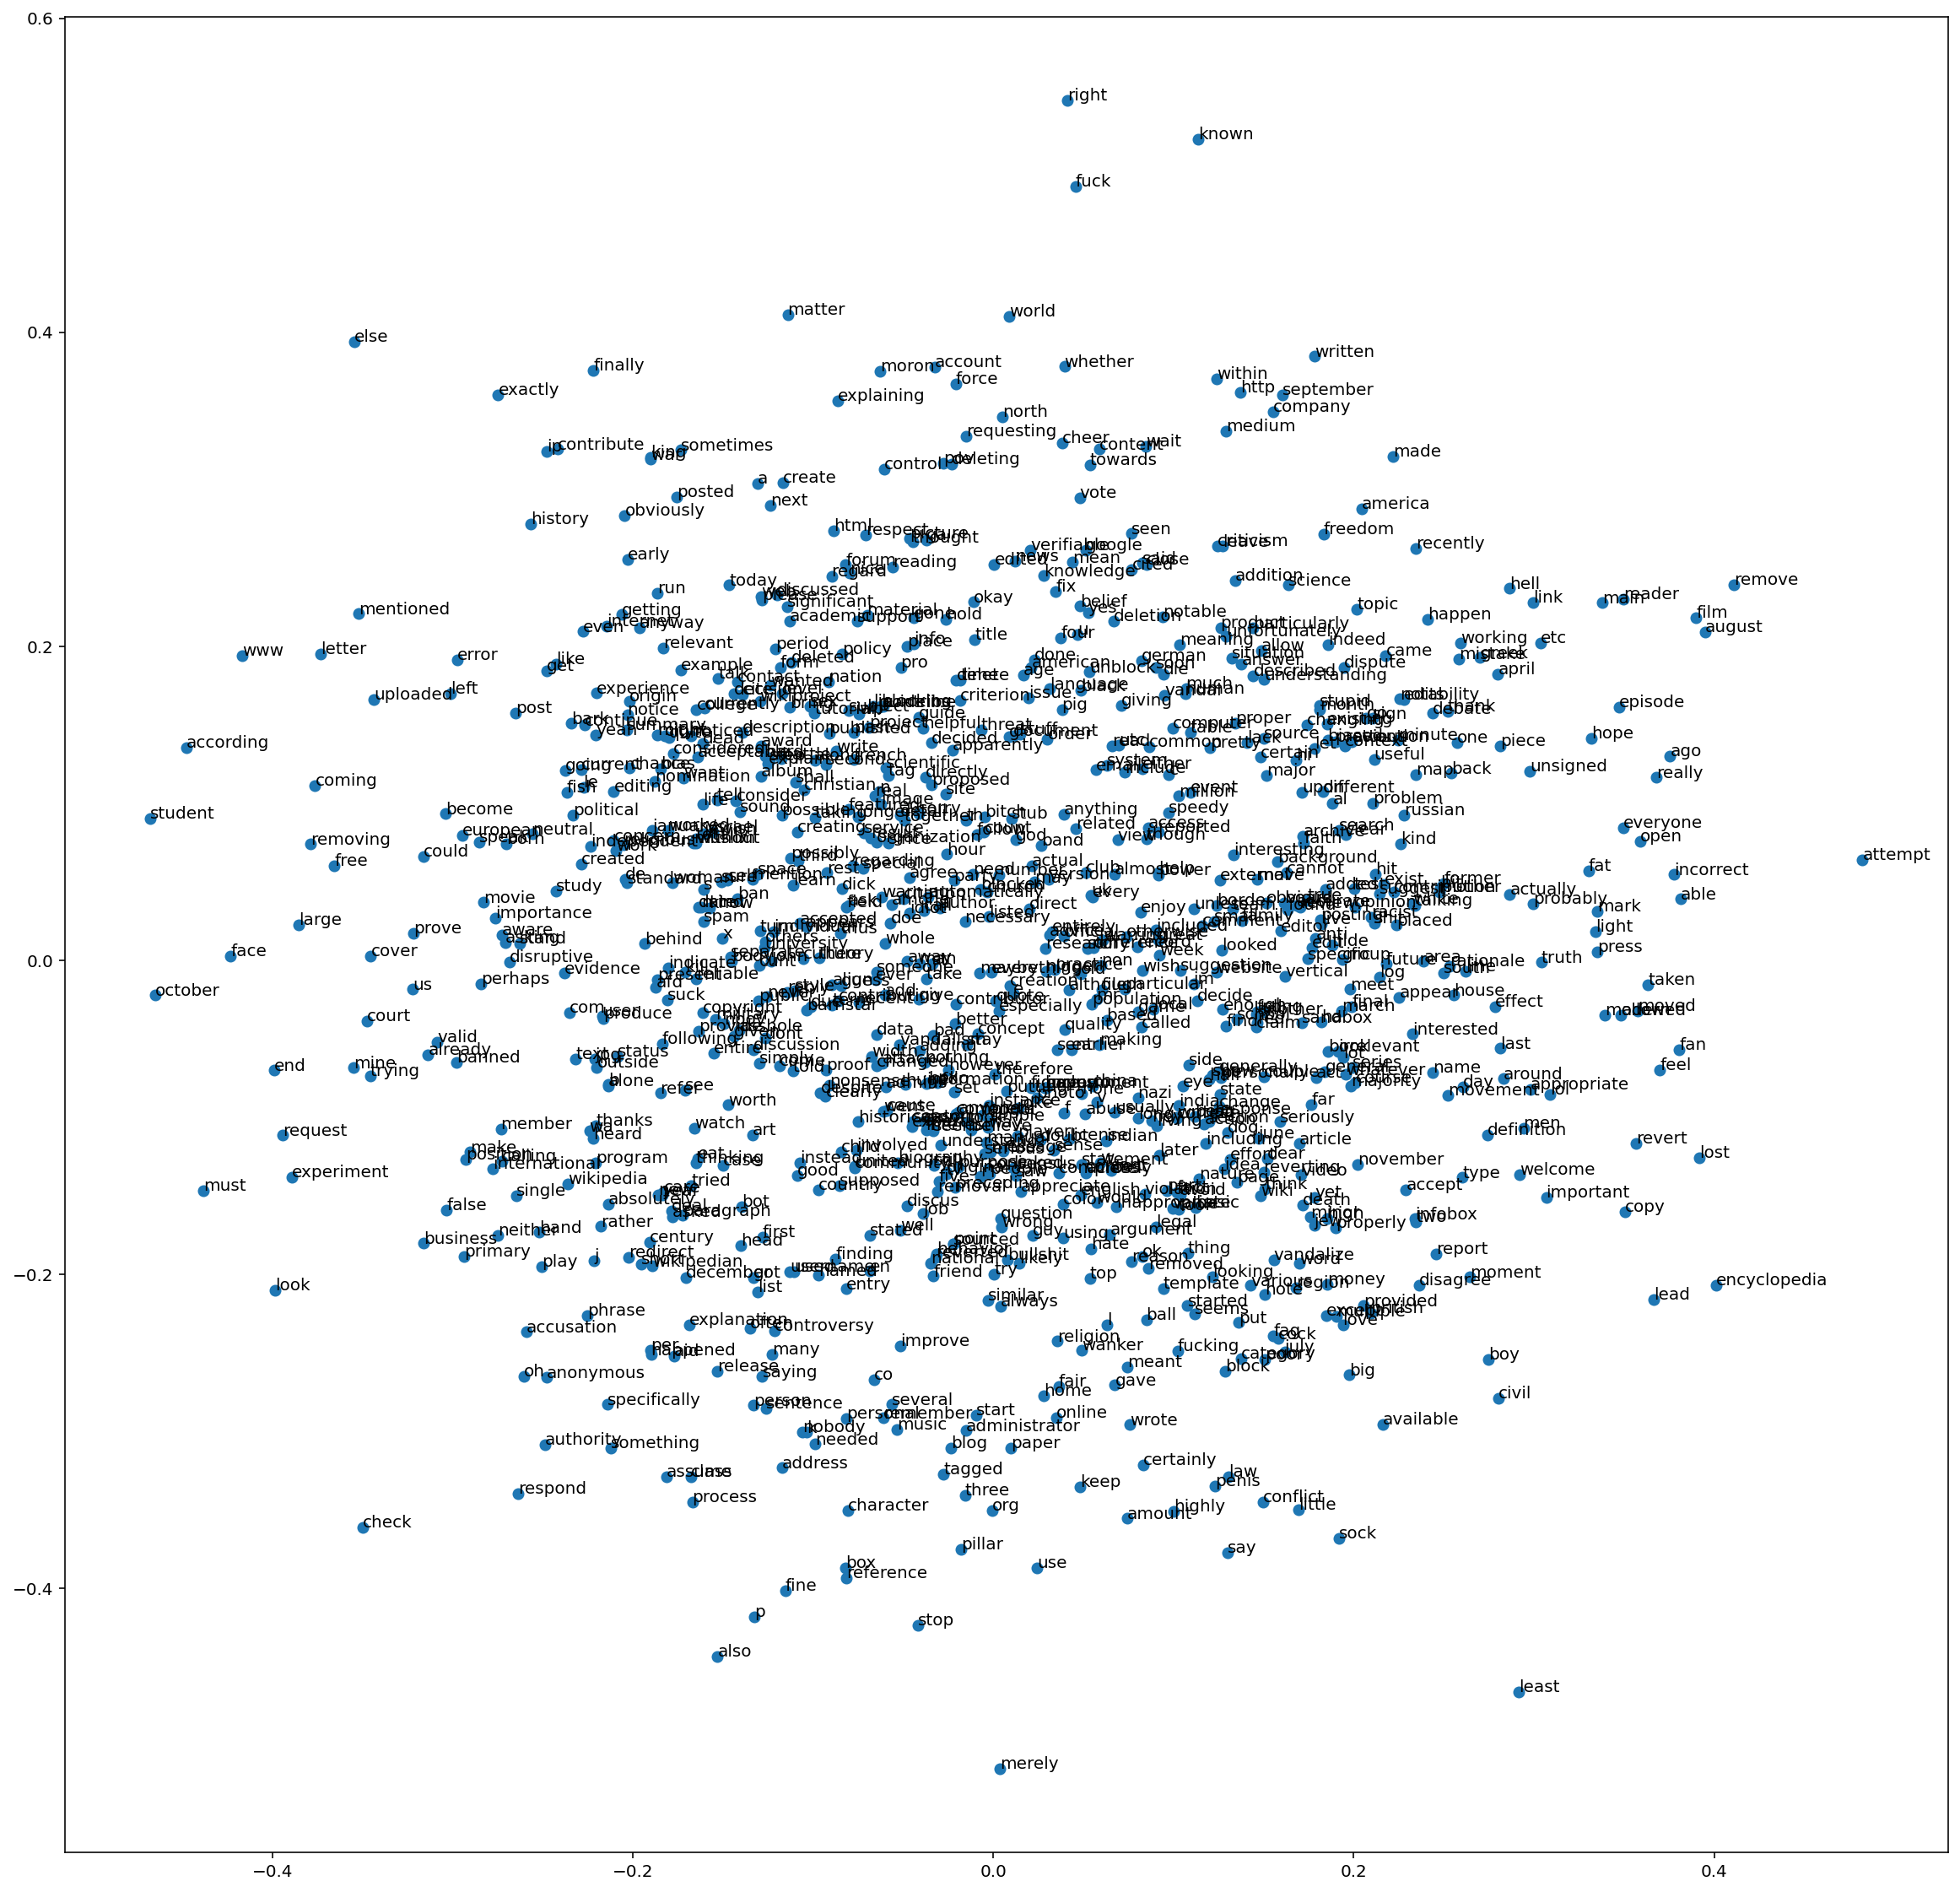

In [162]:
plot_2d_graph(vocabs, xs, ys)

In [109]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', random_state=42)

xys = tsne.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

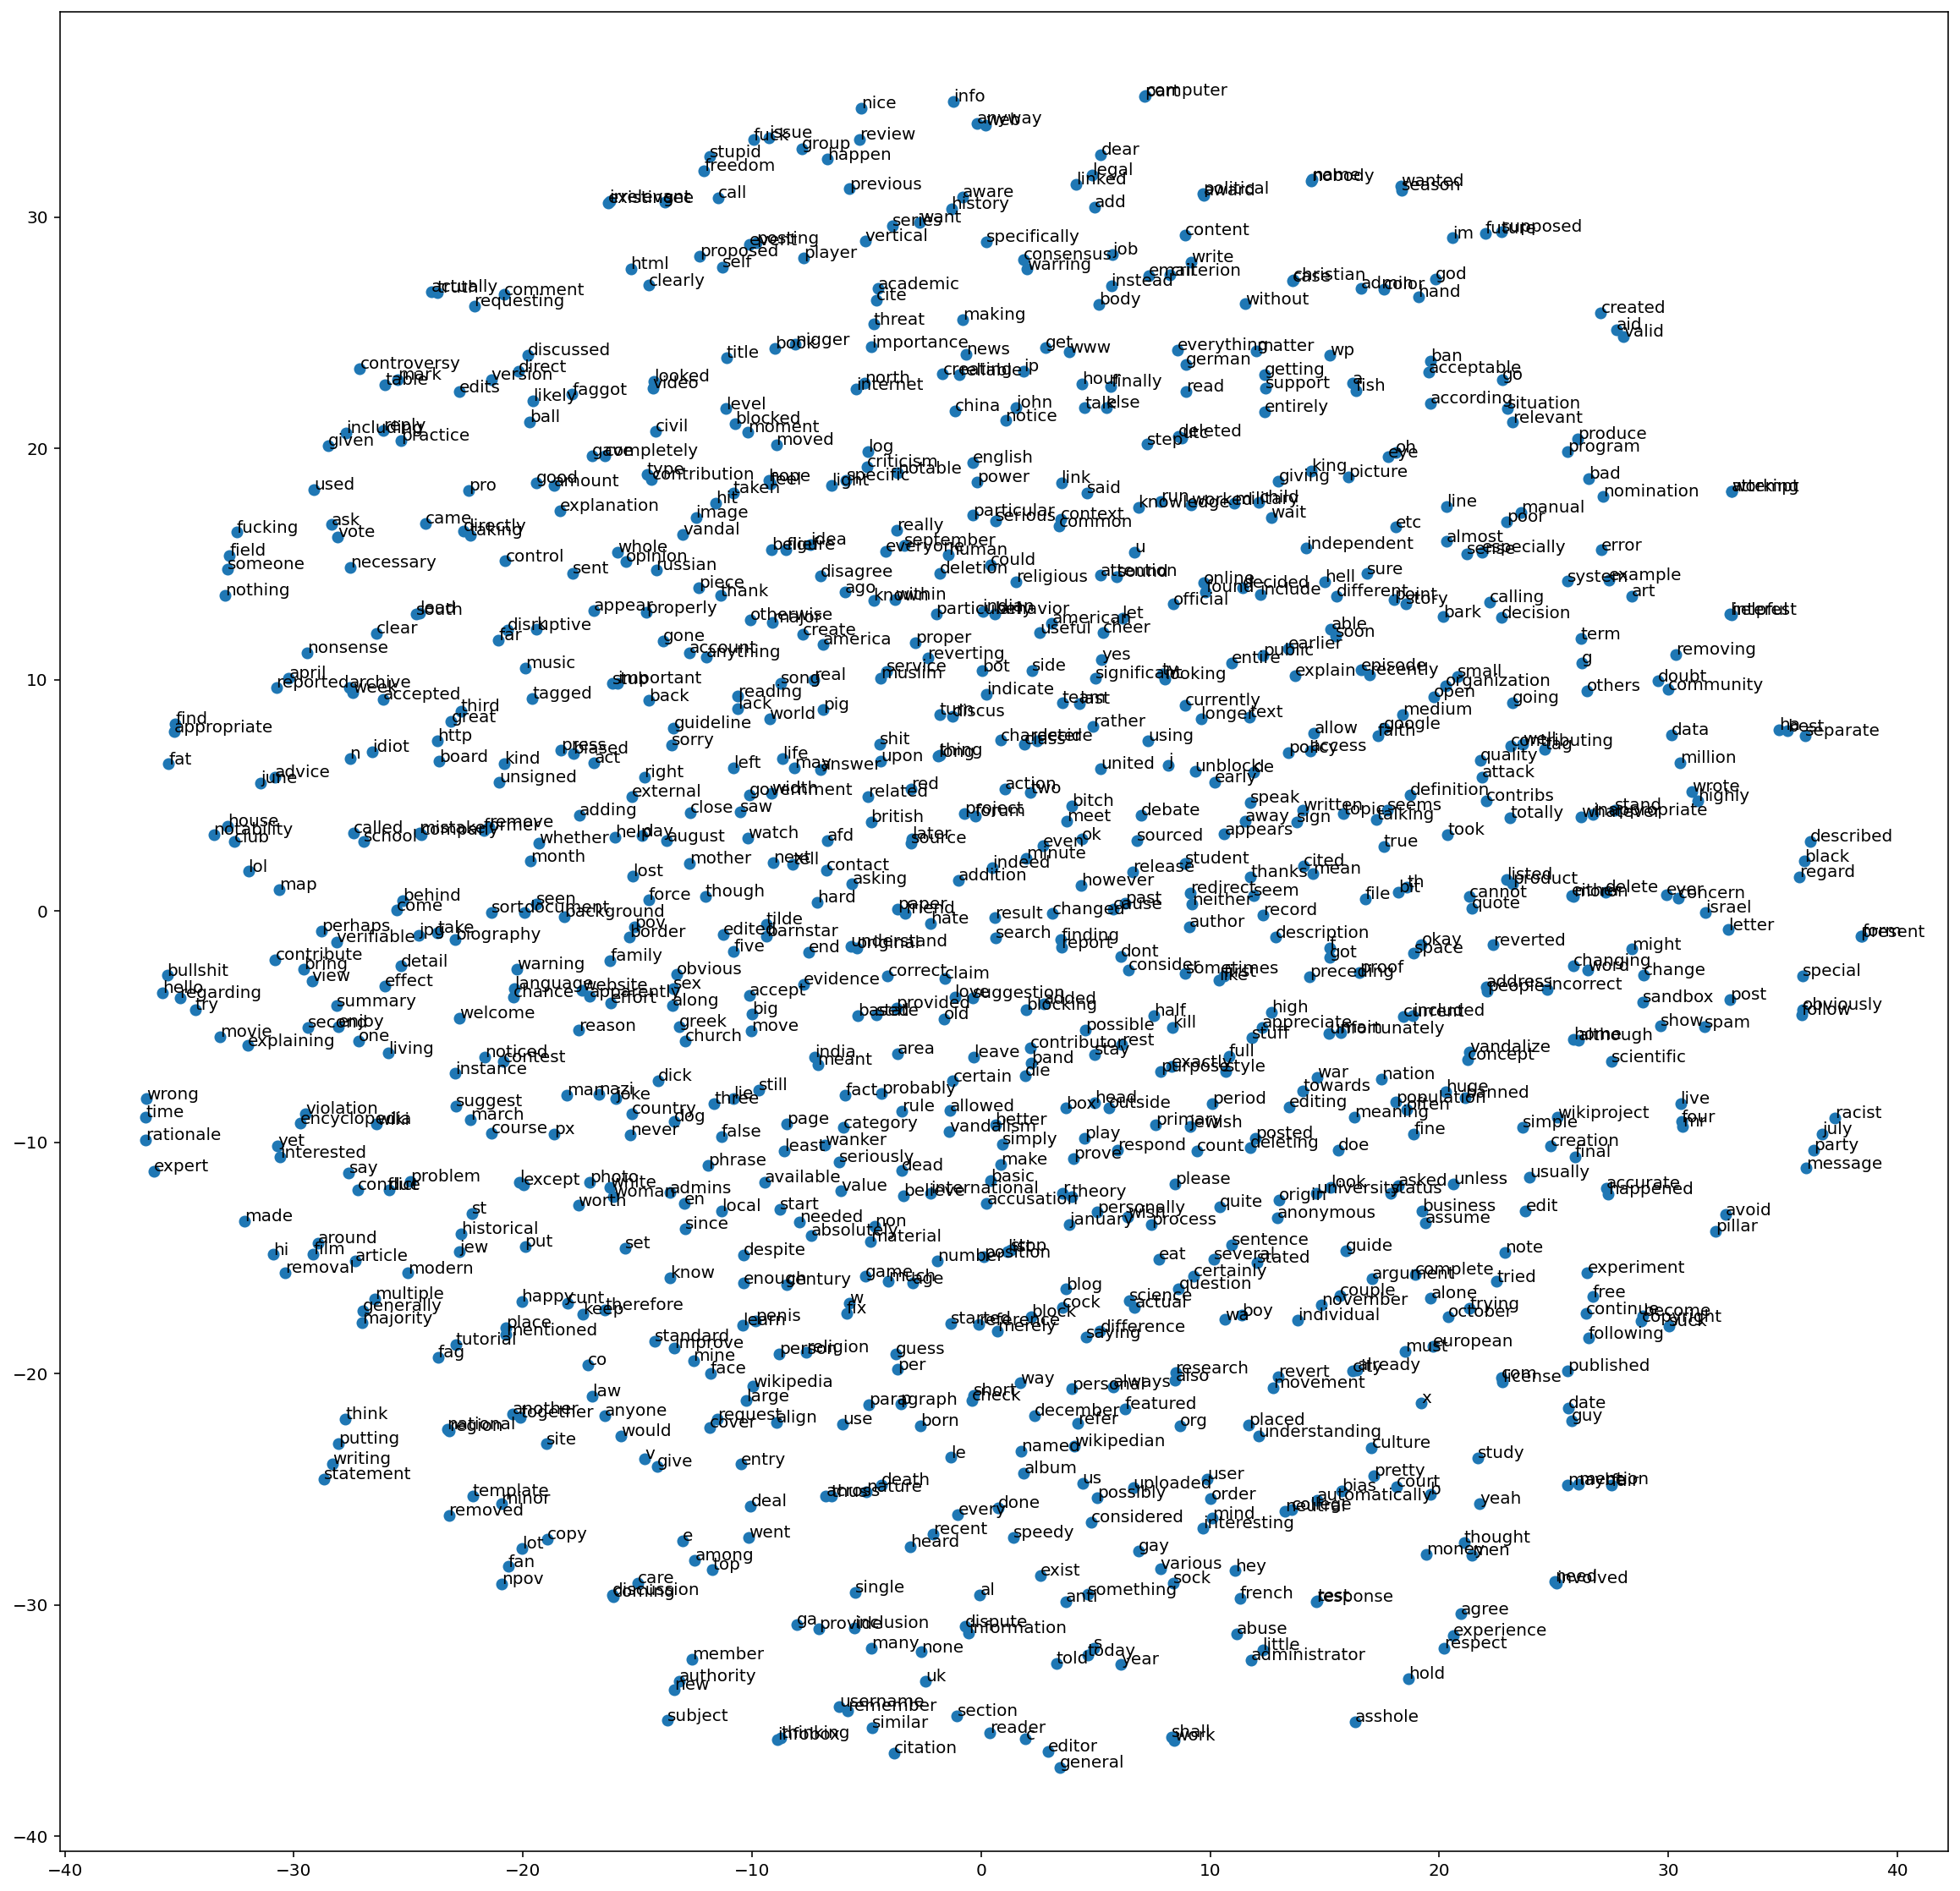

In [110]:
# 값들이 퍼져있는 정도는 TSNE를 사용했을때가 조듬더 잘 펴져있지만, 의미상 비슷하게 분포되어있는 정도는 PCA가 나은듯

plot_2d_graph(vocabs, xs, ys)

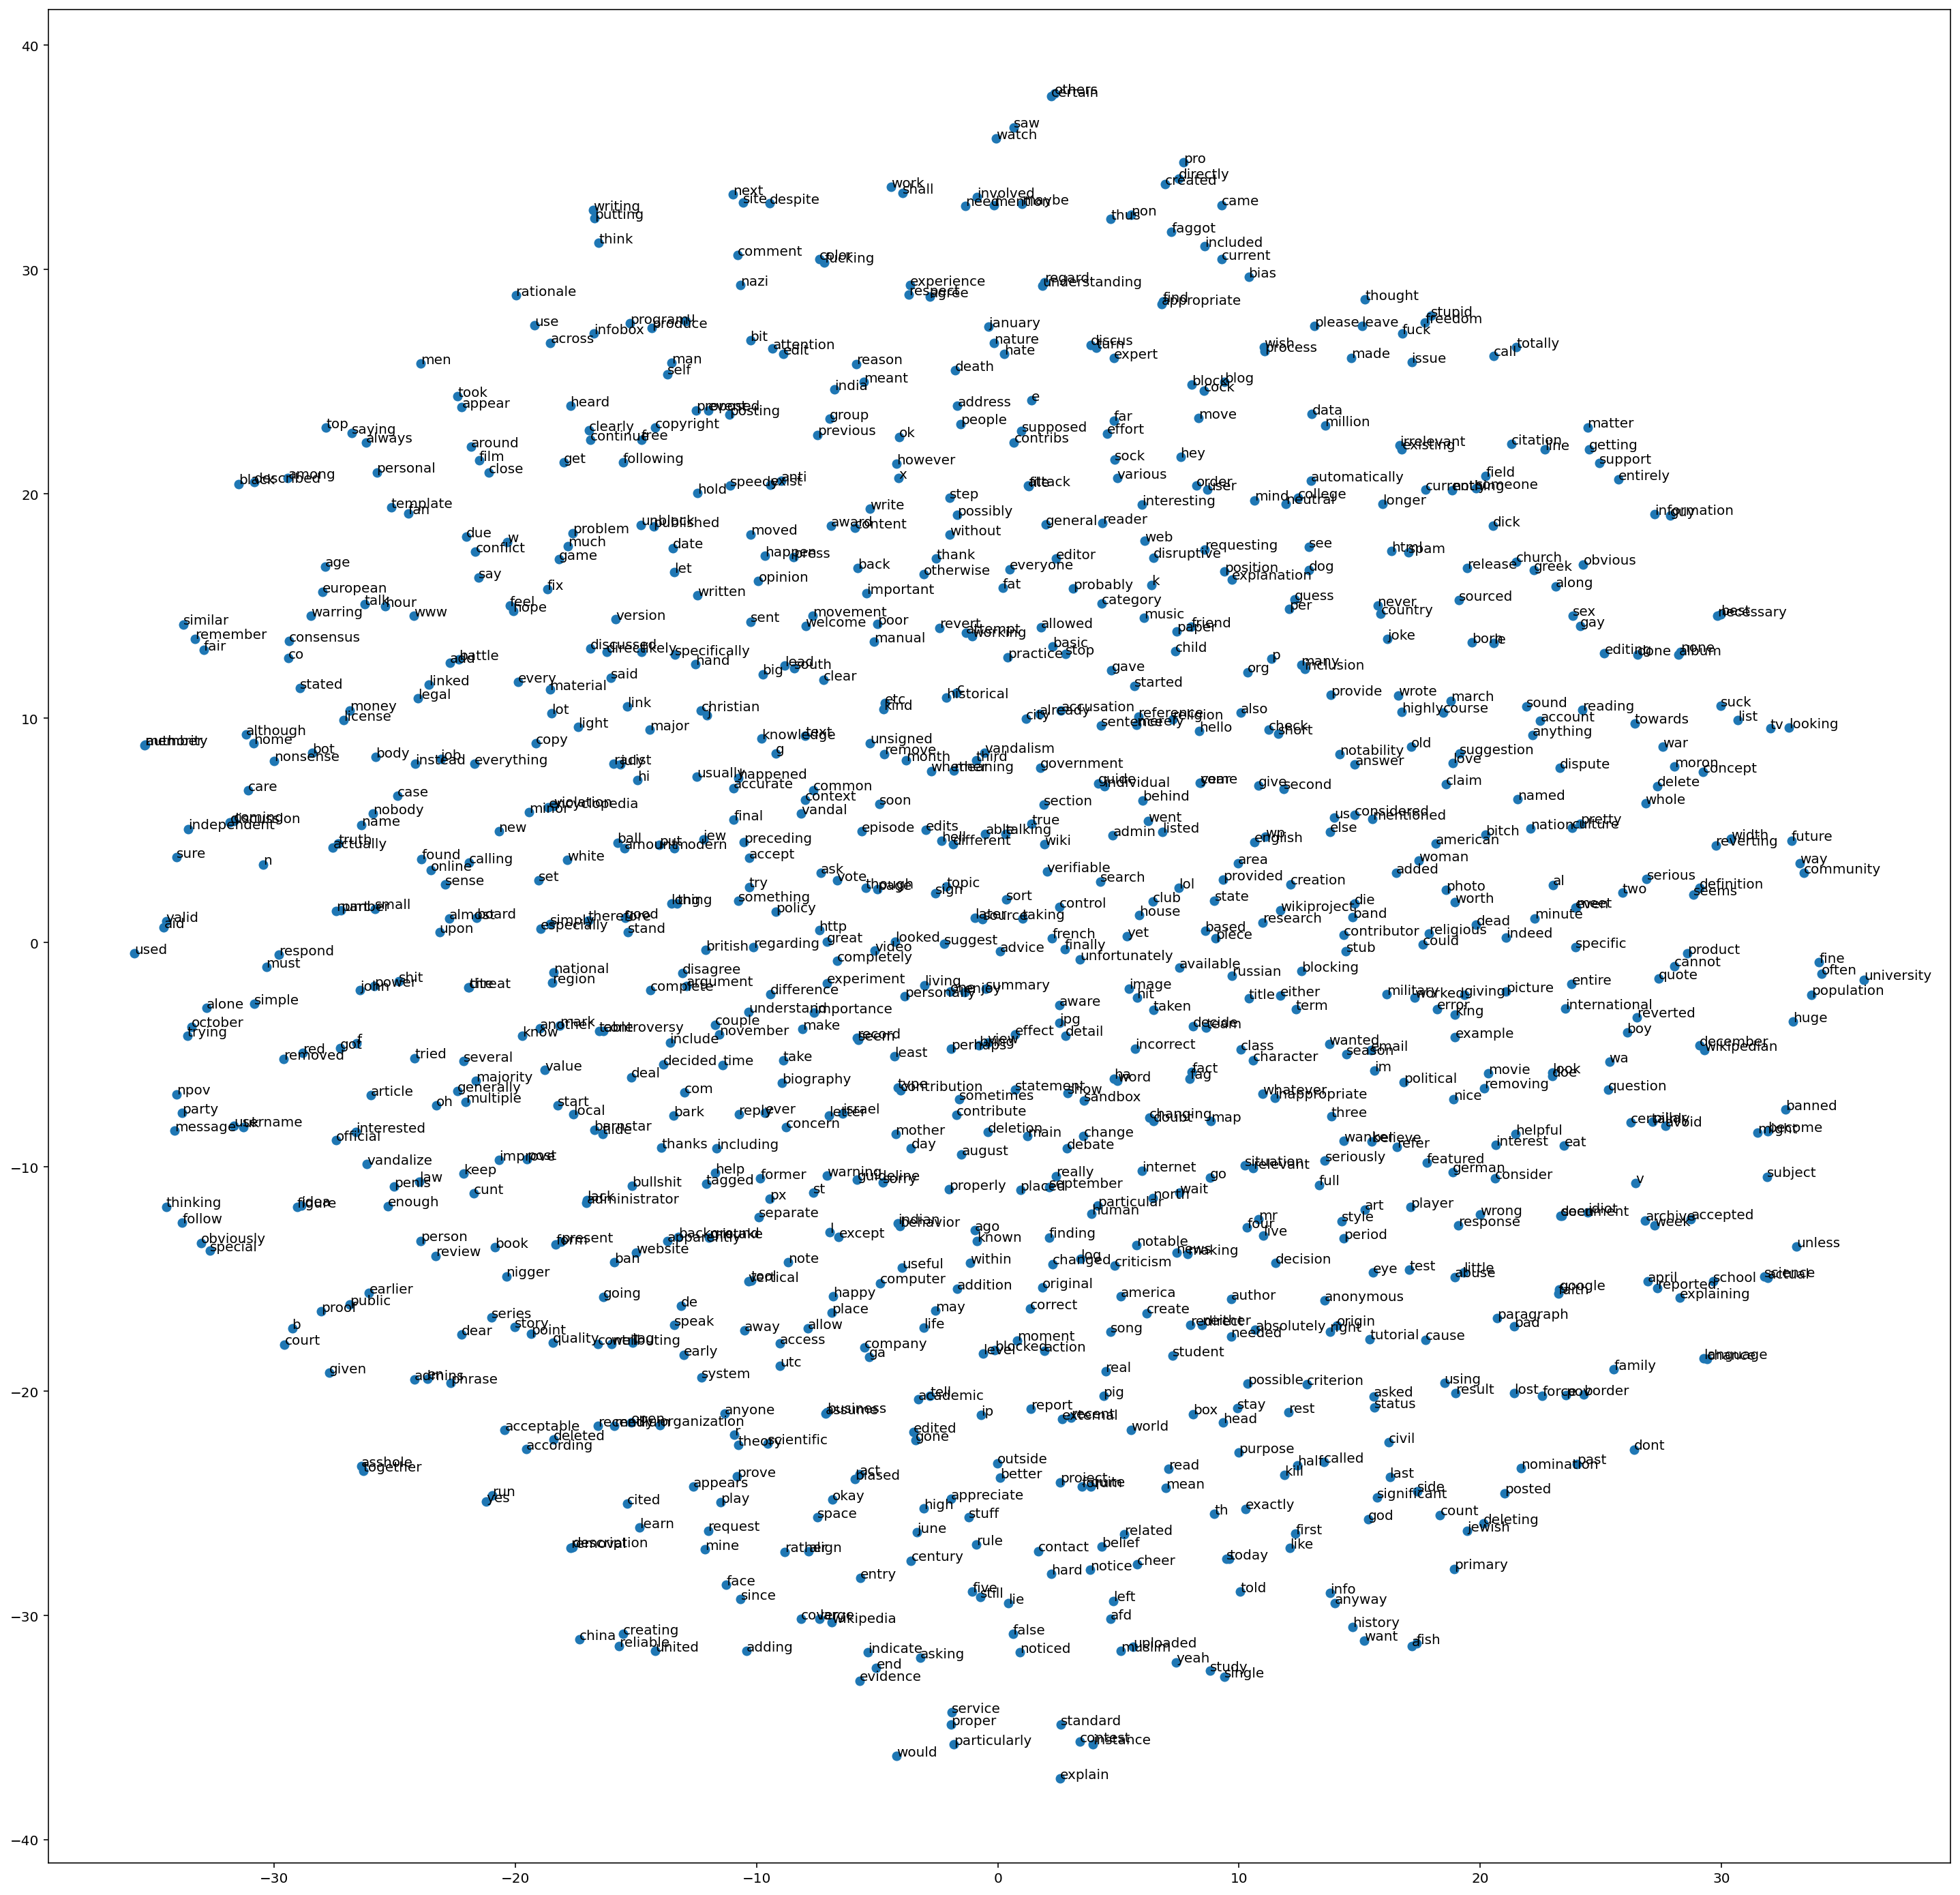

In [163]:
tsne = TSNE(n_components=2, learning_rate=100)
xys = tsne.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

plt.figure(figsize=(25, 25))

plt.scatter(xs, ys)

for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))
    
plt.show()

In [141]:
X_train, X_test, y_train, y_test = train_test_split(w_df.drop(columns='label'), w_df['label'], test_size=0.3, stratify=w_df['label'])

In [142]:
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

0    0.898325
1    0.101675
Name: label, dtype: float64

0    0.898312
1    0.101688
Name: label, dtype: float64

In [ ]:
from PyDictionary import PyDictionary

py_dict = PyDictionary()

meaningful_words = token_words['comment_text'].apply(lambda x : [word for word in x if py_dict.meaning(word, disable_errors=True) != None])